## Description:
######Model type = RNN
######Hidden layers = 128*2
######train seq_len = 500
######model id = new-rnn128-500
######model_name feature and printing more
######want to try epoch down and batch size down, but should keep same for experiment between LSTM and RMM
chars = sorted(list(set(text)))

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

Google Colab Mounting

In [25]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Hyper Params

In [26]:
#data
seq_len = 500
batch_size = 20 #this is changed to fit similar batch number on 500
#model:
hidden_size = 128
n_layers = 2
cell_type = "rnn"
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = 'new-' + cell_type + str(hidden_size) + '-' + str(seq_len) #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"
print(model_id)

new-rnn128-500


Data Loading

In [27]:
import io
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = sorted(list(set(text))) #set will not be the same every time, which cause loss of model before new-rnn-128-200
tchars = sorted(list(set(test_text)))
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))
print(chars)

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Data Preprocessing

In [28]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

434 torch.Size([501, 20])
22 torch.Size([501, 20])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=300, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=200, device='cpu', random=False): #npttext, 200 #0,300 #can use param to set random = True 
    if random:
        l = np.random.randint(0, len(data)-seq_len-2)
    else:
        l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)

    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [33]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=2, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([501, 20, 67]) torch.Size([2, 20, 128])
test forwardc
torch.Size([67]) torch.Size([2, 1, 128])
test cal_accuracy
0.009850000031292439
test random train seq
----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the sweet sound,
That breathes upon a bank of violets,
Stealing and giving odour! Enough; no more:
'Tis not so sweet now as it was before.
O spirit of love! how quick and fresh art thou,
That, notwithstanding thy capacity
Receiveth as the sea, nought enters there,
Of what validity and pitch soe'er,
But
----------prediction----------
J!kgJzH3fX!hJzX W
zKsbd3BAHPN-RHNtSX dx'SUsJdxzbSHUdtrsXNWWNW[xYms S-BrjHc[BRRDcxtS-PUUrFBPxHilN
Bk ABmHpB
MP!rbYPzUmISVbmHW!&PIxdBB.BZqMHKCH
dJKTxJYqBkgNpzt!dKBB CZldPBgD K[ pdxCbxUP;BpWbCftb?KHWzWBPNxXBVjHmSMB;XmmBg.Bd.-mjBPx WB'HB
tdB,V

Build new model

In [34]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2) #omg
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new {}-{} model named {} and record named {} initted".format(cell_type, hidden_size, model_id, rec_name))

new rnn-128 model named new-rnn128-500 and record named rec-new-rnn128-500.pkl initted


Or Load saved model

In [0]:
if LOAD:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    model.load_state_dict(torch.load(model_path+load_model_name, map_location=lambda storage, loc: storage)['model'])
    #print(torch.load(model_path+load_model_name)['model'])
    model.eval() #important
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


Train

In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=200, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [38]:
if not LOAD:
    train()

  0%|          | 0/434 [00:00<?, ?it/s, loss=2.513, test_ac=0.306, train_ac=0.302]


At 1 epoche, loss = 3.112, train ac = 0.201, test ac = 0.208
RNN write with seed Juliet

##############################

Juliet seadrd thene id thol t lawy or dore witht, tour ond her of rothe siI thes
et siatied


D:
Herere his ir wers ans tore mas sithe soure heer somadt ret

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
nS:
Ih::
::
I  ter netorthe toun tn toue  toet tu  
hne te tn e   tu tn  thet  tore  n n   
he tneer n  ter tone    tnd touton 

hen to etn tnetn  tn tet tnto n  tore 

o tn tore tn   te tatetone the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=2.269, test_ac=0.352, train_ac=0.359]


At 2 epoche, loss = 2.393, train ac = 0.331, test ac = 0.340
RNN write with seed Juliet

##############################

Juliet to he mime peded therke wall houy will in of at of bagwy ine melest todp,
Rimked cand in tith pore at Boo set bak how thas, ]e the thel mu thave ceam

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
fS::IR::N::
T  ter nete the tord tf tore  aoet tf  Tote te trto t tf tn  ahet  aore rn n   The tneer n  tet tonh rd tnd toutotn

het tooetn tnetn  tn tet tnto n  torl 
To tn tote tfd  te trtetote the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=2.235, test_ac=0.383, train_ac=0.371]


At 3 epoche, loss = 2.228, train ac = 0.371, test ac = 0.374
RNN write with seed Juliet

##############################

Juliet hat wa betal te close thatthe a atincen prithereaog to me meour him wacking'r, are andd were vould ie to an that and and the that hemam's stons prouf

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
dS::IR :N::
T  tes nhte the tord tf tore  aret tf  Tote te trto t tf tn  ahet  ahr  rn ng  The tnler nh ten tonh rd tnd th totn

het thoetn tnetn  In tet tnto ng torl 
Tn tn tone tfd  te trt tone the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=2.111, test_ac=0.391, train_ac=0.391]


At 4 epoche, loss = 2.156, train ac = 0.382, test ac = 0.393
RNN write with seed Juliet

##############################

Julietels vason an hardold
Inle stis touch
ho, you thou that the to net the wimpy rea!

AELOUS:
And thes, and your mowers word lecldy, the hastide,
Endest t

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
dS::IR :AE:
A  testnhte the tord tf tore  aret tf  Aote te tnto t tf tn  thet  thr  rnhng  The tnler nh ten tonh rt tnd th tetn

het thoetn tnetn 
In tet tnto ng torl 
An tn tone tfd  te trr tone the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=2.084, test_ac=0.410, train_ac=0.398]


At 5 epoche, loss = 2.079, train ac = 0.399, test ac = 0.405
RNN write with seed Juliet

##############################

Juliet fat this stood youl ay bast
And and the wris make, cantendy's breath
Thit the mest wit more fleary me sharme comentt ge menterth
Mescer me thil that 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
dS::I: :AE:
I  testnete the tord tf tore  aret tf  Aode te tntont tf tn  thet  threernhng  The tnler ne ten tonh rt tnd th totn

het thoenn tnetn 
In tev tnso ng torl 
I  tn tone tfd  ta trrttove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=2.019, test_ac=0.428, train_ac=0.422]


At 6 epoche, loss = 2.056, train ac = 0.403, test ac = 0.416
RNN write with seed Juliet

##############################

Julieted my late shave orreston, reade, Lorth he my surthers, and he may now at hores:
To hee as could a do, do it and chain in't mich the wey as net bvith 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
dS::I  :AE:
I  tystnete the sord tf tore  aren tf  Aode te tntont tf tn  thet  thr ernhng  The sreer ne ten tonh rt tnd th tesn

het thoenn tnein 
In tev tnso ng torl 
T  tn tone tfd  ta tarttove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.945, test_ac=0.431, train_ac=0.428]


At 7 epoche, loss = 1.988, train ac = 0.421, test ac = 0.428
RNN write with seed Juliet

##############################

Julieterf'll my meet thus, mist so, for with for sive prome is weir sircking coured or isain:
I hay, Frectart, with Hapuit thy sent his Redore, troun:
Thee 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
dS::H  :AE:
I  tystnete the sorl tf tore  aren tf  Aode te tntont tf tn  thet  ahr ernhng  Ahe srper ne tyn torh rt tnd th tesn

het thaenn tnein 
In tev tnso ng torl 
I  tn tone tf   ta tar tove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.940, test_ac=0.427, train_ac=0.427]


At 8 epoche, loss = 1.966, train ac = 0.428, test ac = 0.432
RNN write with seed Juliet

##############################

Julietes the rence do olfree, do his sundy, you and ming, and ain on in the harn a proptisedo, thoum.

PONFIAN:
I'll say the hamptleoper, you do broronp.

U

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
:S::H  :AE:
I  tystnete the sorl tf tore  arei tf  Aode te tntont tf tn  thet  ahreernhog  Ahe srpertne ten torh rt tnd th tesn

het thaenn tnein 
In tev tnso ng torl  I  tn tone tf r te tarttove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.940, test_ac=0.435, train_ac=0.428]


At 9 epoche, loss = 1.958, train ac = 0.427, test ac = 0.434
RNN write with seed Juliet

##############################

Julieter!

KY VACILO CEER:
So a warn a man, we loves haves to soony and I sweef be thein are liod this now hassey:
To thap your the crenter!

SIANIO:
I to t

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::H  :AE:
I  tystnete the sorl tf tore  arei tf  Aode te tntont tf tn  ahet  aoreernhog  Ahe srpertne ten torh rt and th tedn

het thaann tnein 
In tev tnso ng torl  I  tn tone tf r ta tar tove the 

##############################



  0%|          | 2/434 [00:00<00:21, 19.77it/s, loss=1.868, test_ac=0.447, train_ac=0.448]


At 10 epoche, loss = 1.924, train ac = 0.431, test ac = 0.443
RNN write with seed Juliet

##############################

Juliething,
She sear and of a colse. What his verise ul right
There grael the are by sare you beces with more countrenty;
For I commertibeline if beto with 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::H   AE:
I  tystnete the sorl tf tore  arei tf  Aode te tntont tf tn  thet  aoreernhog  Ahe srpertoe ten torh rt and th tosn

het thaann tnein 
In tev tnso ng totl  I  tn tone tf r ta lar tove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.858, test_ac=0.457, train_ac=0.448]


At 11 epoche, loss = 1.858, train ac = 0.448, test ac = 0.447
RNN write with seed Juliet

##############################

Julieters king and sanger the commentans they, by sind?

SICONOZE:
W.
A brickesone of thy foill death them-'tio?

SYECHAS:
Themping,
So this brother, a pise

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::H   AG:
I  tystnete the sarl tf tore  arei tf  Tode te tneentetf tt  thet  aoreernhog  Ahe srpertoe tyn tork rt tnd th todn

het thaann tnain 
In tev tnso lg totl  I  tn tone tf r ta lar tove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.923, test_ac=0.460, train_ac=0.432]


At 12 epoche, loss = 1.843, train ac = 0.453, test ac = 0.454
RNN write with seed Juliet

##############################

Juliet that poor hanking not come's there good my worth it so the wild that, and it is sEf to no will, wither likes we, free the ling.

WALLOUS:
Yet hame in

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::I   AG:
I  tystnete the sarl tf tove  arei tf  Aode te tneentetf tt  ahet  aoreernhog  Ahe srpertoe ten tork rt and th tosn

het thaann tnain 
In tev t so lg totl  I  tn tone tf r ta lar tove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.851, test_ac=0.438, train_ac=0.458]


At 13 epoche, loss = 1.877, train ac = 0.445, test ac = 0.449
RNN write with seed Juliet

##############################

Juliethes ented most me he have should here a love of them Begiant Seard, my more of the mort and thou stozen it I wo the fair these her strome this woush
T

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::C   AG:
I  tystnete the sarl tf tore  arei tf  Aode te tneentetf tt  thet  aoreerthog  Ahe srpertoe ten tork rt tnd th tosn

het toaann tnain 
In tev t so lg totl  T  tn tone tf r ta larttove the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.859, test_ac=0.447, train_ac=0.444]


At 14 epoche, loss = 1.834, train ac = 0.459, test ac = 0.459
RNN write with seed Juliet

##############################

Juliet
And swall to my tood dethim;
I thou shall us with thee siming sear no mide thear'd for seaver say.

TRASTASY:
Mathure a tone hee: when there of unwil

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::V  SAG:
I  tystnete the sarl tf tive  arei tf  Aode te tneeltetf tt  thet  aoreerthog  Ahe srpertoe ten tork rt tnd th tosn

het thaann tnain 
In tev t so ng totl  I  tn tone tf r te larttive the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.796, test_ac=0.475, train_ac=0.460]


At 15 epoche, loss = 1.841, train ac = 0.455, test ac = 0.459
RNN write with seed Juliet

##############################

Juliet,
In sight exery.

CLOEN:
So man, sir.

DO$ IO:
How when father's
Wooth honger's argnon
That my manfers,
Whom in hands when in better.

KING HANGLO:
S

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::C  SAG:
I  tystnete the sarl tf tive  arei tf  Aode te tneeltetf tt  thet  aoreerthog  Ahe srpertoe tyn tork r  tnd th tosn

het thaann tnain 
In tev t so ng totl  I  tn tone tf r ta lar tive the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.828, test_ac=0.471, train_ac=0.467]


At 16 epoche, loss = 1.794, train ac = 0.467, test ac = 0.469
RNN write with seed Juliet

##############################

Juliet in and make her begunter hath the stain
con, when in loved dnegen, Afeched to be make my took mest in him are that druakind with then with more in le

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::V  SAG:
I  tystnete the sarl tf tive  arei tf  Aode te tneeltetf tt  thet  aoreerthog  Ahe srpertoe ten tork rt and th tosn

het thaann tnains
In tev t mo ng totl  I  tn tone tf r te lar tive the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.775, test_ac=0.467, train_ac=0.477]


At 17 epoche, loss = 1.861, train ac = 0.457, test ac = 0.465
RNN write with seed Juliet

##############################

Juliety you so splitere of the not it thou by sir, that years here, come the from and now, thy more you lought our destemse,
Thea manise, where high a morto

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sorl tf tive  arei tf  Aode te tneeltetf tt  thet  toreerthog  Ahe srpertoe ten tork d  tnd th tosn

het toaann tnains
In tev t mo ng totl  Ir tn tone tf r te lar toke the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.773, test_ac=0.475, train_ac=0.475]


At 18 epoche, loss = 1.812, train ac = 0.464, test ac = 0.473
RNN write with seed Juliet

##############################

Julieter: a' the good not my poon man;
Which no bring this groth houses of sicked, I will a morreat?

VARONIA:
Then, go dising the patter, for the fear, by 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sorl tf tive  arei tf  Aove te tneeltetf tt  thet  aoreerthog  Ahe srpertoe ten tork d  tnd th tosn

het toaann tnains
In tev t mo ng totl 
I  tn tone tf r te larttike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.830, test_ac=0.477, train_ac=0.459]


At 19 epoche, loss = 1.794, train ac = 0.469, test ac = 0.473
RNN write with seed Juliet

##############################

Juliet thou wilt this throth, not me have my sharred, that my like they friel speak are but here and have of an the twing to his happest uny a profurs as be

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sarl tf tive  arec tf  Aove te tneeltetf tt  thet  aoreesthog  Ahe srpeatoe ten tork d  and th tosn

het thaann tnains
In tev t mo ng totl  I  tn tone tf r te lar tike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.771, test_ac=0.475, train_ac=0.475]


At 20 epoche, loss = 1.829, train ac = 0.461, test ac = 0.473
RNN write with seed Juliet

##############################

Julietly and string reging hath benders'd and then mack it are though as made the live you she hast of the shall to purcheds a falt me, their counton, I wil

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sarl tf tive  arec tf  Aove te tneeltetf tt  thet  toreesthog  Ahe srpertoe ten tork d  tnd th tosn

het thaann tnains
It tev t mo ng totl  I  tt tone tf r te lar tike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.777, test_ac=0.457, train_ac=0.475]


At 21 epoche, loss = 1.793, train ac = 0.471, test ac = 0.476
RNN write with seed Juliet

##############################

Julieton.

Forth of sear stay marise and hear;
Are her conselfor kind for sen into of look make word of man
If thou more would
The exerling Toldier-montly c

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sarl tf tive  arec tf  Aove te tneeltetf tt  thet  toreecthog  Ahe srpertoe ten tork d  and th tosn

het thaann tnains
It tev t mo ng totl  I  tn tone tf r te lar tike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.683, test_ac=0.478, train_ac=0.514]


At 22 epoche, loss = 1.764, train ac = 0.475, test ac = 0.473
RNN write with seed Juliet

##############################

Julieter he their must end warries,
Thou king it were my porpures on to spires it est your magrest what to make a gived Hellow for Roding to me here of my f

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sarl tf tive  arec tf  Aove te tnceltetf tt  thet  toreecthog  Ahe srpertoe ten tork d  tnd th todn

het toaann tnains
It tev t mo ng totl 
I  tt tone tf r te larttike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.763, test_ac=0.480, train_ac=0.477]


At 23 epoche, loss = 1.754, train ac = 0.481, test ac = 0.473
RNN write with seed Juliet

##############################

Juliet ow; the lest brope.

PLUCTINTRUS:
When my father with I was and this champor, of lark corress the could the word to your dingly is the will as the pa

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sarl tf tive  arec tf  Aove te tncelteaf tt  thet  toreecthog  Ahe srperioe ten tork d  and th tods

het toaann tnains
It tev t mo ng totl  I  tt tone tf r te lar tike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.771, test_ac=0.477, train_ac=0.473]


At 24 epoche, loss = 1.780, train ac = 0.469, test ac = 0.477
RNN write with seed Juliet

##############################

Julieti
That excoul have an thou well, sir he in to the loid of the hings in perse me, an of him?
How the doplain Home me not encehter to but he
vilanbert, 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnete the sarl tf tive  arec tf  Aove te tnceltetf tt  thet  toreecthog  Ahe srperioe ten tork d  and th todn

het thaann tnains
It tev t mo ng totl  I  tn tone tf r ta larttike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.759, test_ac=0.475, train_ac=0.488]


At 25 epoche, loss = 1.738, train ac = 0.479, test ac = 0.472
RNN write with seed Juliet

##############################

Julietor for thee refore I shall the beling pradenate: my love thou are your thouse the sings and the done, and banother pragaress bestiefm:
A king not go o

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnhte the sarl tf tive  arec tf  Aove te tncelteaf tt  thet  toreecthog  Ahe srpeaioe ten tork d  and th tod 

het thaann tnains
tt tev t mo ng totl  I  tt tone tf r ta lar tike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.812, test_ac=0.483, train_ac=0.466]


At 26 epoche, loss = 1.731, train ac = 0.490, test ac = 0.487
RNN write with seed Juliet

##############################

Julietle, be dound with from her have speak him; so to part of the supper him;
Fir megt, in the fiart,
What the pearour. The e'er.

Firs:
If my or the strev

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnhte the sarl tf tive  arec tf  Aove te tnceltetf tt  thet  toreecthog  Ahe srpeaioe ten tork d  and th tods

het thaann tnains
tt tev t mo ng totl  T  tt tone tf r ta larttike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.712, test_ac=0.492, train_ac=0.488]


At 27 epoche, loss = 1.777, train ac = 0.471, test ac = 0.487
RNN write with seed Juliet

##############################

Julieters,
To hone, whoith who this not will mad make her prain as many all thou in with but of chorge of a mady thought,
To did sore wanting tell enemes,
I

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnhte the sarl tf tive  arec tf  Aove te tnceltetf tt  thet  toreecthog  Ahe srperioe oen tork d  and th tod 

het thaann tnains
It tev t mo ng totl  T  tt tone tf r ta lnr tike the 

##############################



  1%|          | 3/434 [00:00<00:16, 26.66it/s, loss=1.730, test_ac=0.491, train_ac=0.483]


At 28 epoche, loss = 1.756, train ac = 0.479, test ac = 0.488
RNN write with seed Juliet

##############################

Julietwast and tower that here other at say be nace, what none on my lord!

RENTIO:
Why, I
Lurle.

TELONIUS OF SENARIA:
I pay this shall fay as the sink me 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SAA:
I  tystnhte the sarl tf tive  arec tf  Aove te tncelteaf tt  ahet  aireecthog  Ahe srpeaioe ten tork d  and th tod 

het thaann tnains
It tev t mo ng totl  I  tf tone tf r ta larttike the 

##############################



  0%|          | 0/434 [00:00<?, ?it/s, loss=1.661, test_ac=0.475, train_ac=0.501]


At 29 epoche, loss = 1.768, train ac = 0.476, test ac = 0.485
RNN write with seed Juliet

##############################

Juliet.

BRUTHIUS:
Nay, this tainty desenter is not thou may have are to ence and shold me have you, you would speak to mines me shall a think say a marts w

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SUA:
I  tystnhte the sarl tf tive  arec tf  Aove te tnceltetf tt  thet  tireecthog  Ahe srpeaioe ten tork d  and th tod 

het thaann tnains
tt tev t mo ng totl  I  tf tone tf r ta larttike the 

##############################



100%|██████████| 434/434 [00:15<00:00, 28.65it/s, loss=1.738, test_ac=0.493, train_ac=0.485]



At 30 epoche, loss = 1.742, train ac = 0.486, test ac = 0.489
RNN write with seed Juliet

##############################

Juliety of with then and thy man thou art tim a she both, the arm
As done?

CORIANA:
A heath,
And we thee
I do has with young hrowning?
The takes and their 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
eS::VF SUA:
I  tystnhte the sarl tf tive  arec tf  Aove te tnceltetf tt  thet  ticeecthog  Ahe srpeaioe ten tork d  and th tod 

het thaann tnains
tt tev t mo ng totl  I  tf tone tf r ta larttike the 

##############################

Tranning records saved to disk.


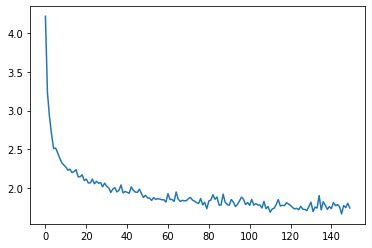

In [39]:
plt.figure()
plt.plot(record['loss'])
plt.show()

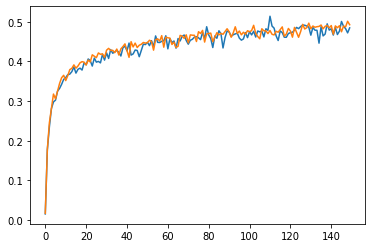

In [40]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [41]:
print(calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device))
print(calc_accuracy(model, train_data, n_batch=len(train_data)-1, device=device))

0.48993808031082153
0.5008082985877991


In [42]:
print(generate(model, device)) #default tau = 0.8

Juliet.

DENEDENCE:
Thou trues boy into presente! There he not these had thou should like whose drother?

MARK LEoN HeNth this everility baken now the masbine, and they well to burning.

LAUK:
I prove you, the daynation him
This a
fattery our readon.

ROTER ELECBETHA:
No for I am not shall grady how and t


In [43]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

juliety the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shall the shal 

julietrynoursWeM Senfrwi.;
Gmarz amm f; hx?

KIO:
Mike frlmeg eaptors--'D!!
Hy ep!i
Dugneqfhyffod
An vumpet;: promodiwacl:
NENUt Suolip isidly
Grpzo!n!, Bna, sue yre dell's'! Gfow pertlacu'alich cfoa;
nom?
Bud, bu'mes freystode thou
jnudys
No
 Ondoy;
Dvew is llan!--ywer burrew, nEfZFried. tor'd Kffilish;
 



In [44]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') 

i willess bear
Nother: unging his well,
Or hit, his love is will poor thy shall gentle extent to lister for there's sent both I shall so cill in another: and,
I's'f bid for crown to true and the love thou have would the pary to his poor thing
Est a shand;
That sweet his pliothy more my paim the where
And more of my face of thy worthy will you have before be than you,
And whill not say with your seaver upon patseccamient should the mactor lie therefore womany torne, and you befole me a grace you more
u 



In [47]:
random_train_seq(model, nptext, seq_len=200, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
lrst tatisen:
Tu ore ti sroveed tnd torther  ae r ty theak 

CNl:
Ioeak  aoeak 

CArst Sathsen:
Tou sre t l tettnde  teteer th tid thet th toiene 

CNd:
Ieatnde  
Ieaende  

CArst Sathsen:
Torst  aou 


In [46]:
seeds = ["I", "Juliet", "KING:", "my lord", "flower", "soldier", "my son", "father", "hope", "death"]
for seed in seeds:
    print("------------seed: {}-----------".format(seed))
    print(generate(model, device, seed=seed, predict_len=500, tau=0.8))

------------seed: I-----------
I:
O furm you you have fell and bant on out as a give that are me;
Or drand your breaser on to be both ten them at the dust'd and I am I do sin rome, wood dritherens and say horse distain misteron the holderly him thate, tear that suffel of this of there of of here what should for her your sweets or him surzose he crese, sorrow'd have every leave.

LOUNTIUS:
Thou part I come hold see that
I take shall answeas my scood, thy rendint is hold do mady the mourniw, than I drownerat, tend is this is vis
------------seed: Juliet-----------
Julieth hassain, and so liech tined in to my too honour earn'd. I know and a men long knowming by your graids time time to fearth him but have noge good power in thou breads, and the queen of the how with your lifucting vills thou daminy, then and that come, I'll the wield wich.
When him I know night betreis the sent queen'd, we firth, I know I bark;
For he is I do men;
'task bound of my lord men! see a tongue me the lase and t